### data loading and initial exploring

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_csv('car data.csv')

# Initial exploration
print(df.head())
print("\nData shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

Data shape: (301, 9)

Data types:
 Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Driven_kms         int64
Fuel_Type         object
Selling_type      object
Transmission      object
Owner              int64
dtype: object

Missing values:
 Car_Name         0
Year             0
Selling_Price 

preprocessing and feature engg

In [2]:
# Extract brand from Car_Name
df['Brand'] = df['Car_Name'].str.split().str[0]

# Create age feature instead of year
df['Age'] = 2023 - df['Year']  # Assuming current year is 2023

# Drop unnecessary columns
df = df.drop(['Car_Name', 'Year'], axis=1)

# Convert categorical features
categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission', 'Owner', 'Brand']
numerical_features = ['Present_Price', 'Driven_kms', 'Age']

# Target variable
target = 'Selling_Price'

# Check unique values in categorical features
for col in categorical_features:
    print(f"{col}: {df[col].unique()}")

Fuel_Type: ['Petrol' 'Diesel' 'CNG']
Selling_type: ['Dealer' 'Individual']
Transmission: ['Manual' 'Automatic']
Owner: [0 1 3]
Brand: ['ritz' 'sx4' 'ciaz' 'wagon' 'swift' 'vitara' 's' 'alto' 'ertiga' 'dzire'
 'ignis' '800' 'baleno' 'omni' 'fortuner' 'innova' 'corolla' 'etios'
 'camry' 'land' 'Royal' 'UM' 'KTM' 'Bajaj' 'Hyosung' 'Mahindra' 'Honda'
 'Yamaha' 'TVS' 'Hero' 'Activa' 'Suzuki' 'i20' 'grand' 'i10' 'eon' 'xcent'
 'elantra' 'creta' 'verna' 'city' 'brio' 'amaze' 'jazz']


eda

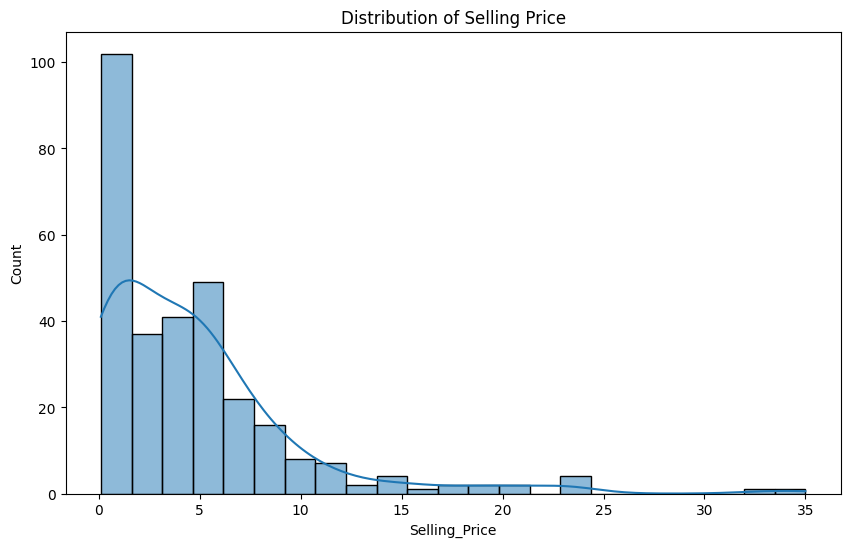

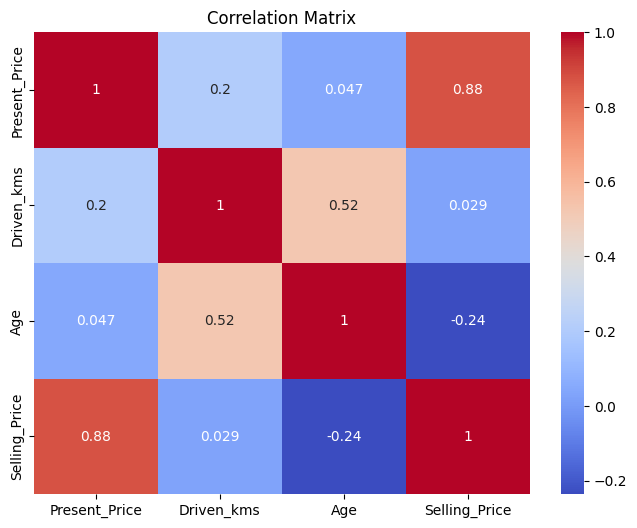

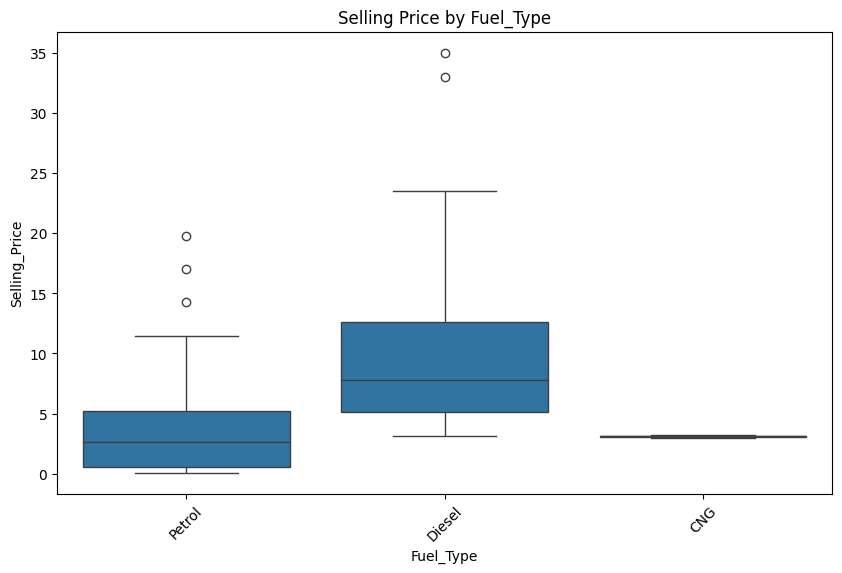

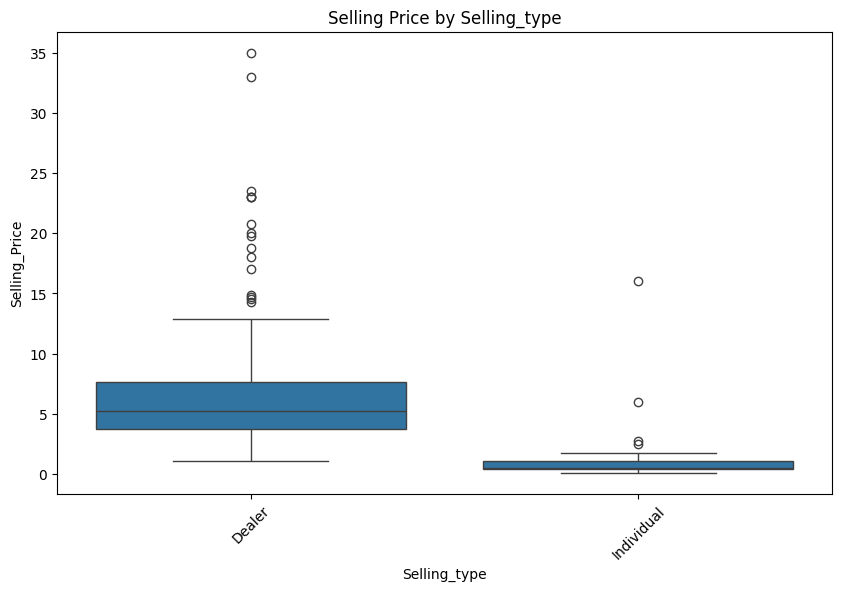

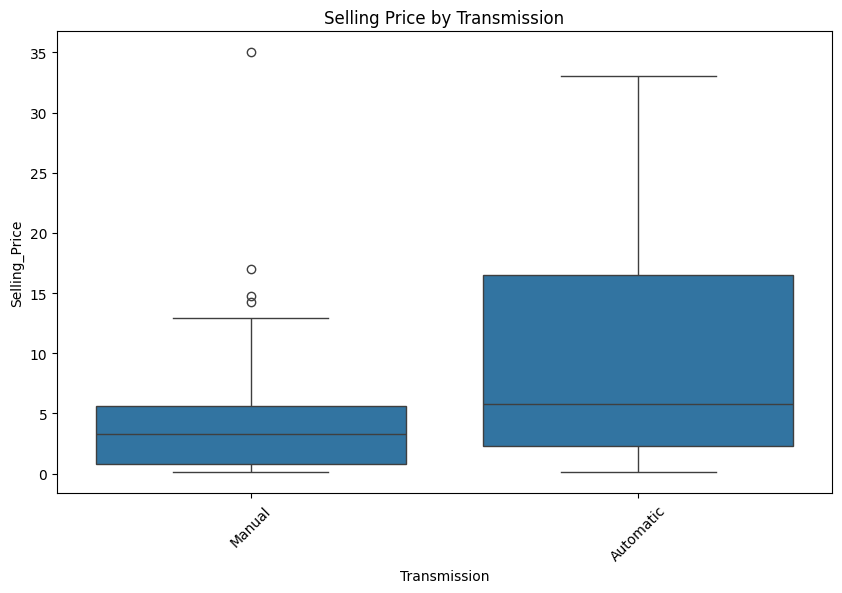

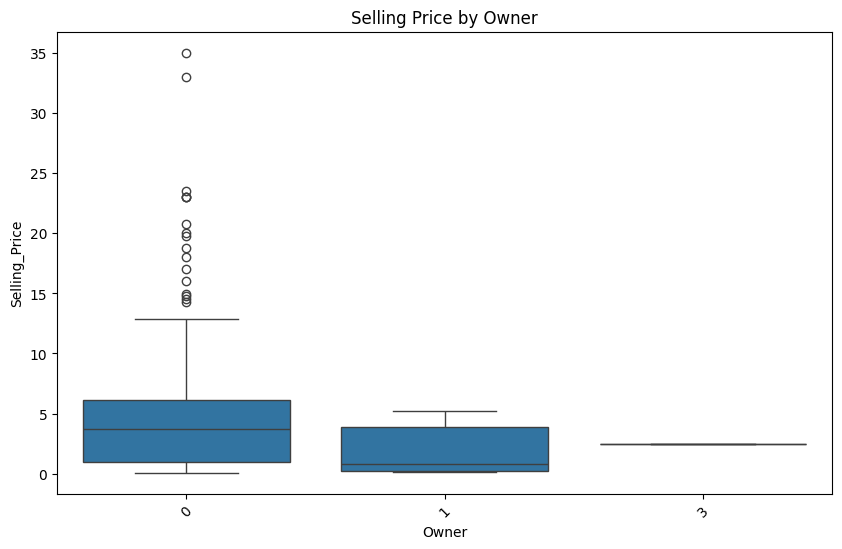

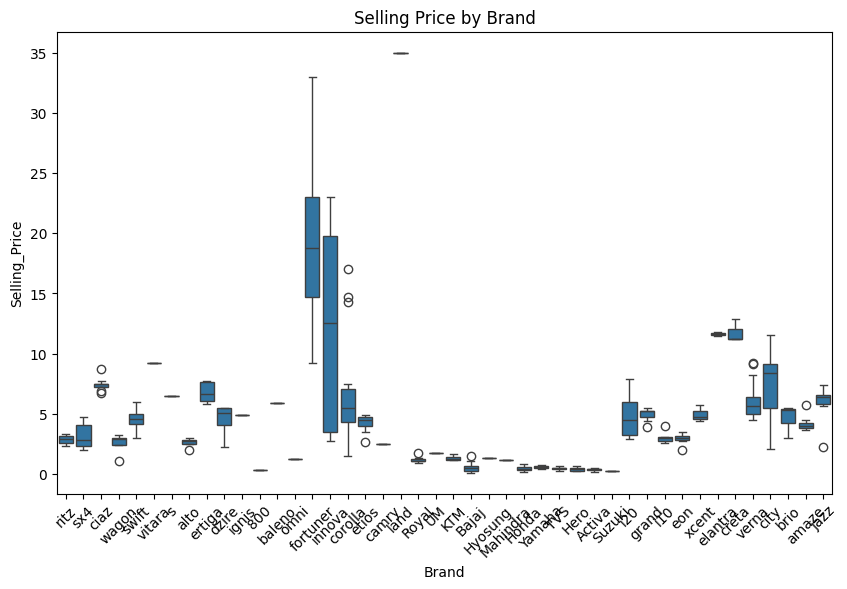

In [3]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df[target], kde=True)
plt.title('Distribution of Selling Price')
plt.show()

# Correlation matrix for numerical features
corr_matrix = df[numerical_features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplots for categorical features
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y=target, data=df)
    plt.title(f'Selling Price by {col}')
    plt.xticks(rotation=45)
    plt.show()

### data splitting

In [4]:
# Split data into features and target
X = df.drop(target, axis=1)
y = df[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (240, 8)
Test set size: (61, 8)


preprocessing pipelinr

In [5]:
# Preprocessing for numerical features
numerical_transformer = StandardScaler()

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### model training

In [6]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Root Mean Squared Error: 0.89
R-squared: 0.97


### hyperparametre tuning

In [7]:
# Define parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized RMSE: {rmse:.2f}")
print(f"Optimized R-squared: {r2:.2f}")

Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Optimized RMSE: 0.90
Optimized R-squared: 0.96


### feature importance analysis

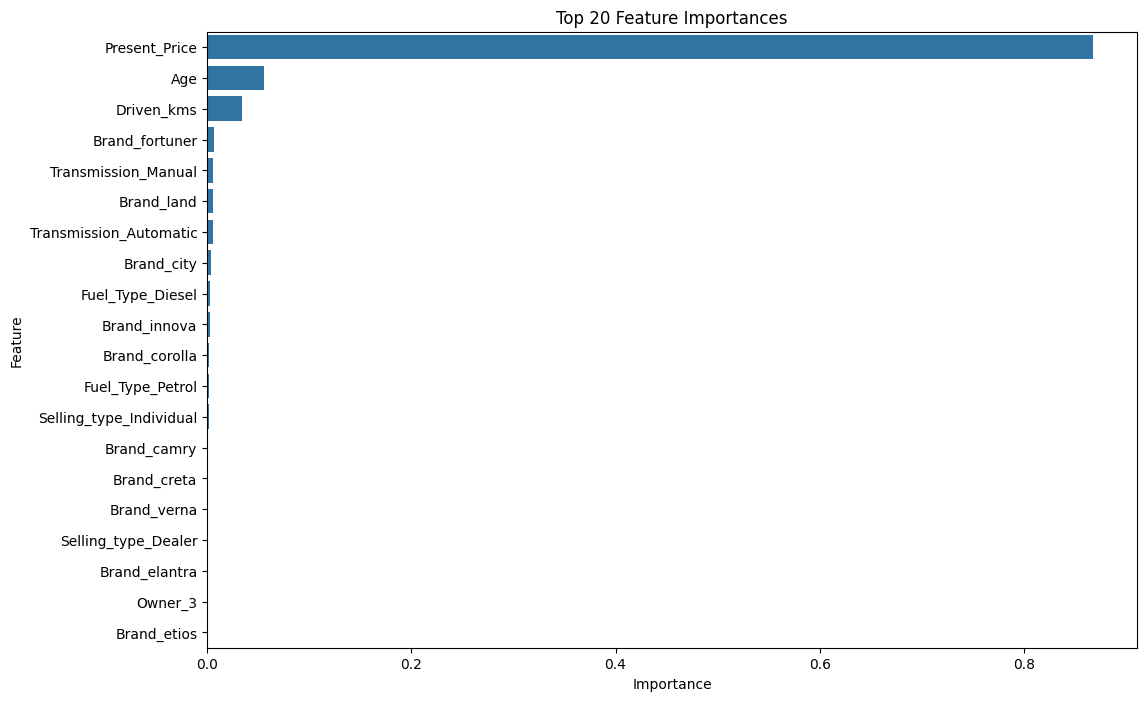

In [8]:
# Get feature names after one-hot encoding
preprocessor.fit(X_train)
feature_names = numerical_features + list(
    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
)

# Get feature importances from the best model
importances = best_model.named_steps['model'].feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

### model interpretation and visualisation

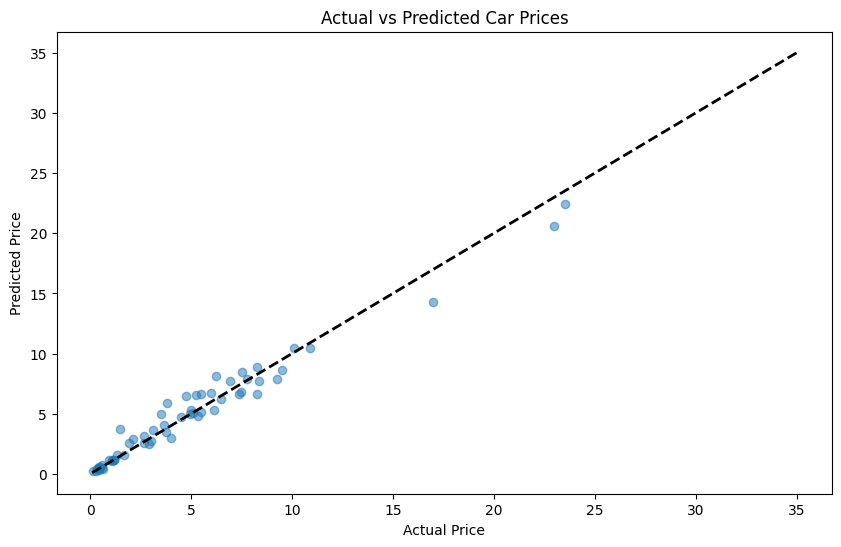

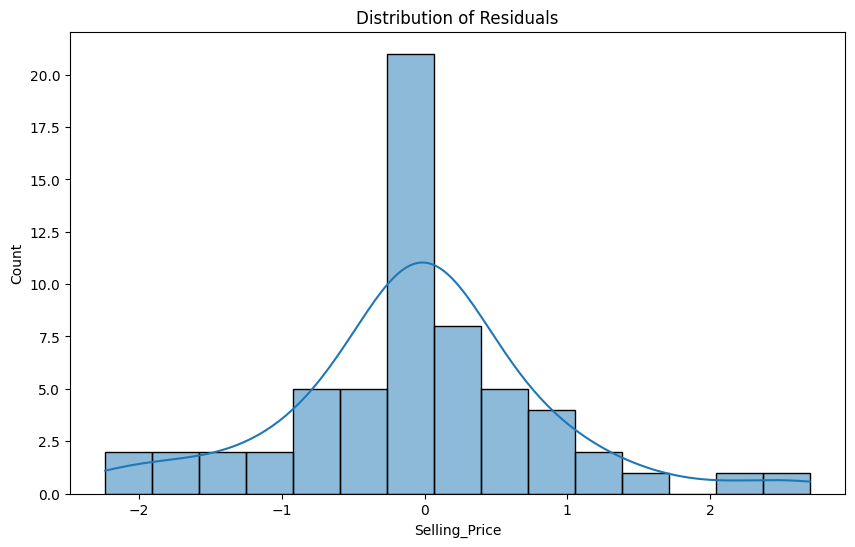

In [9]:
# Actual vs Predicted values plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

### predictions on new data

In [10]:
# Example of predicting on new data
new_data = pd.DataFrame({
    'Present_Price': [8.5],
    'Driven_kms': [25000],
    'Fuel_Type': ['Petrol'],
    'Selling_type': ['Dealer'],
    'Transmission': ['Manual'],
    'Owner': [0],
    'Brand': ['Honda'],
    'Age': [5]
})

predicted_price = best_model.predict(new_data)
print(f"Predicted Selling Price: {predicted_price[0]:.2f} lakhs")


Predicted Selling Price: 7.09 lakhs
